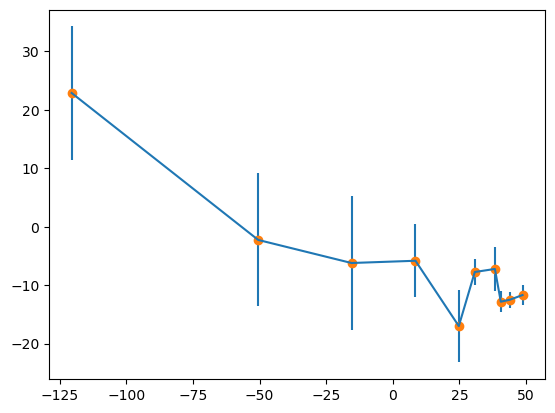

In [2]:
# Check Bayesian
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
from scipy import stats
import statsmodels.api as sm
import pymc as pm

data_dir = 'C:/crs/proj/2025_shoreline_fits/'
fn = 'Northshore_LT_intersects.csv'
df = pd.read_csv(data_dir+fn)

# Convert to datetime format
df["date"] = pd.to_datetime(df["ShorelineI"], format="%m/%d/%Y")

# Function to convert datetime to decimal year
def datetime_to_decimal_year(dt):
    year = dt.year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    end_of_year = pd.Timestamp(f"{year+1}-01-01")
    decimal_year = year + (dt - start_of_year).total_seconds() / (end_of_year - start_of_year).total_seconds()
    return decimal_year

# Apply function to convert each date
df["decimal_year"] = df["date"].apply(datetime_to_decimal_year)
df

# pick a transect
tid = 2776
tdf = df[df["TransectID"] == tid]
x = tdf['decimal_year'].values - 1970.
y = tdf['Bias_Dista'].values
yu = tdf['Bias_Uncer'].values
plt.errorbar(x,y,yu)
plt.plot(x, y, 'o')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


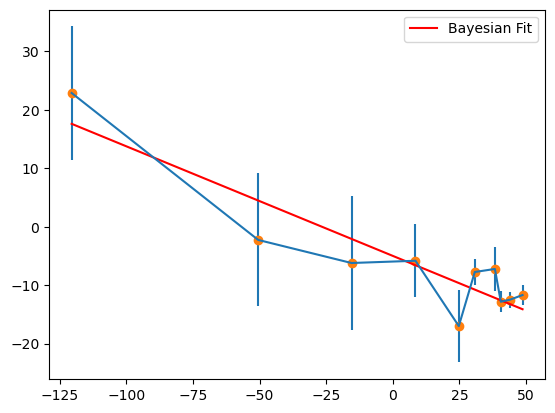

In [6]:
# Generate synthetic data
np.random.seed(42)

# Fit an ordinary least-squares model to the data
X = np.column_stack( (x, np.ones_like(x) ))
weights = 1./( yu**2 )

# Ordinary least-squares fit
OLSfit = sm.OLS(y, X).fit()
OLS_slope, OLS_intercept = OLSfit.params
OLS_pvalues = OLSfit.pvalues        
# Compute the 95% confidence interval for all parameters
OLSconf_int = OLSfit.conf_int(alpha=0.05)  # Default is 95% CI       
# Extract the slope's confidence interval
OLSslope_CI = OLSconf_int[0]  # First row corresponds to the slope
OLSslope_list.append( OLS_slope )
OLSslope_CIlow_list.append( OLSslope_CI[0] )
OLSslope_CIhi_list.append( OLSslope_CI[1] )
OLSr2_list.append( OLSfit.rsquared )

# Define Bayesian Model
with pm.Model() as model:
    # Priors for slope and intercept
    slope = pm.Normal("slope", mu=0, sigma=10)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=slope * x + intercept, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Extract posterior mean estimates
slope_post = trace.posterior["slope"].mean().values
intercept_post = trace.posterior["intercept"].mean().values

X = np.column_stack( (x, np.ones_like(x) ))
weights = 1./( yu**2 )

# Ordinary least-squares fit
OLSfit = sm.OLS(y, X).fit()
OLS_slope, OLS_intercept = OLSfit.params
OLS_pvalues = OLSfit.pvalues        
# Compute the 95% confidence interval for all parameters
OLSconf_int = OLSfit.conf_int(alpha=0.05)  # Default is 95% CI       
# Extract the slope's confidence interval
OLSslope_CI = OLSconf_int[0]  # First row corresponds to the slope
OLSslope_list.append( OLS_slope )
OLSslope_CIlow_list.append( OLSslope_CI[0] )
OLSslope_CIhi_list.append( OLSslope_CI[1] )
OLSr2_list.append( OLSfit.rsquared )

# Plot result
plt.errorbar(x,y,yu)
plt.plot(x, y, 'o')
plt.plot(x, slope_post * x + intercept_post, color="r", label="Bayesian Fit")
plt.legend()

In [5]:
df_data = pd.read_csv("C:/crs/proj/2025_shoreline_fits/RcodeForChris/dataForBLR_MAns2769_2869.csv")
df_prior= pd.read_csv("C:/crs/proj/2025_shoreline_fits/RcodeForChris/priorsForBLR_MAns2769_2869.csv")
print(df_data)
print(df_prior)

     transNum      dates      shore
0        2770   8.496478  -6.815000
1        2770  24.748694 -18.461837
2        2770  30.747449  -9.571891
3        2770  38.290382  -4.346098
4        2771   8.496478  -2.921057
..        ...        ...        ...
207      2867  38.290382 -15.195135
208      2868   8.496478   0.760713
209      2868  24.748694  -1.023978
210      2868  30.747449  -8.234798
211      2868  38.290382 -14.466233

[212 rows x 3 columns]
    transNum  prior_a_mean  prior_a_std  prior_b_mean  prior_b_std  \
0       2770     -1.123585    11.382507     -0.264250     0.081733   
1       2771     -1.348423     5.703849     -0.199141     0.040957   
2       2772     -7.738491     5.090858     -0.030238     0.067619   
3       2773     -5.237634     7.382589     -0.180563     0.053011   
4       2774           NaN          NaN           NaN          NaN   
..       ...           ...          ...           ...          ...   
90      2864    -17.645140     7.097929     -0.011905 